# PP5 - Mildew Detection in Cherry Leaves

## Notebook 3 - Modelling and Evaluation

### Objectives

* Fetch data from kaggle and prepare data for further processes.


### Inputs

* Dataset: [Kaggle](https://www.kaggle.com/datasets/codeinstitute/cherry-leaves/data)

| **input**       |          |        |
|-----------------|----------|--------|
| **train/**      | healthy  | mildew |
| **test/**       | healthy  | mildew |
| **validation/** | healthy  | mildew |


### Outputs


---

## Preparation

### Manage Directories

**Change working directory**

In [1]:
import os

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/ml-mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir('/workspace/ml-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
working_dir = os.getcwd()
working_dir

'/workspace/ml-mildew-detection-in-cherry-leaves'

**Set Input Directory**

In [5]:
dataset_dir= 'input/cherry-leaves'
train_path = dataset_dir + '/train'
val_path = dataset_dir + '/validation'
test_path = dataset_dir + '/test'
print(f"Train Set Path: {train_path}")
print(f"Validation Set Path: {val_path}")
print(f"Test Set Path: {test_path}")

Train Set Path: input/cherry-leaves/train
Validation Set Path: input/cherry-leaves/validation
Test Set Path: input/cherry-leaves/test


**Set Output Directory**

In [6]:
version = 'v1'

In [7]:
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

print(file_path)

Old version is already available create a new version.
outputs/v1


**Set Label Names**

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'mildew']


**Load Image shape**

In [9]:
import joblib

In [10]:
image_shape = joblib.load(filename=f'outputs/{version}/avg_image_shape_train.pkl')
image_shape

(256, 256, 3)

---

## Analysis of Data Distribution across Sets and Labels

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")


In [12]:
def display_data_distribution(dataset_dir, file_path):
    '''
    Display the distribution of data across different sets and labels

    Parameters:
        dataset_dir (str): The directory containing the datasets
        file_path (str): The directory where the output images will be saved

    Returns:
        None
    '''
    data = []
    for folder in ['test', 'train', 'validation']:
        folder_path = os.path.join(dataset_dir, folder)
        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            frequency = len(os.listdir(label_path))
            data.append({'Set': folder, 'Label': label, 'Frequency': frequency})

    df_freq = pd.DataFrame(data)

    custom_palette = sns.color_palette("viridis", len(df_freq['Label'].unique()))

    # Display numerical data
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    table = plt.table(cellText=df_freq.values,
                      colLabels=df_freq.columns,
                      cellLoc='left',
                      loc='left')
    table.set_fontsize(10)
    for key, cell in table.get_celld().items():
        cell.set_linestyle('-')
        cell.set_edgecolor('lightgray')
    plt.savefig(os.path.join(file_path, 'labels_distribution_table.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # Plotting the bar plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette=custom_palette)
    plt.title('Distribution of Labels in Different Sets', fontsize=16, fontweight='bold')
    plt.xlabel('Set', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.savefig(os.path.join(file_path, 'labels_distribution_bar.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # Plotting the pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(df_freq.groupby('Label')['Frequency'].sum(), labels=None,
            autopct='%1.1f%%', startangle=140, colors=custom_palette)
    plt.title('Total Data in Each Label', fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.legend(df_freq['Label'].unique(), fontsize=12, loc='lower right')
    plt.savefig(os.path.join(file_path, 'labels_pie_chart.png'), bbox_inches='tight', dpi=150)
    plt.show()

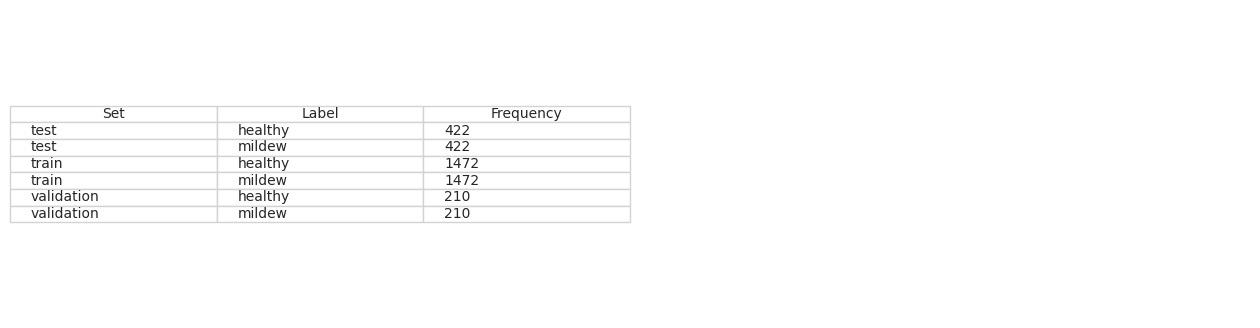

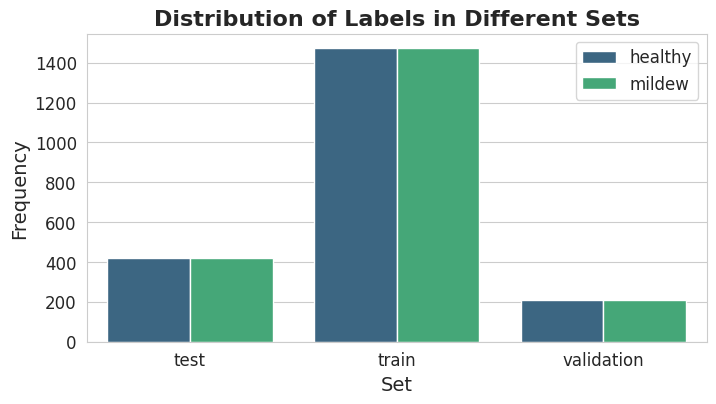

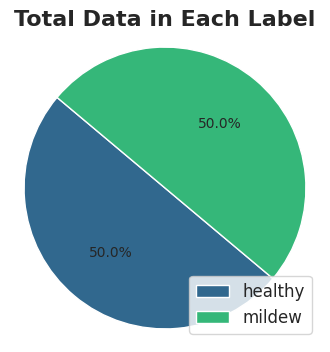

In [13]:
display_data_distribution(dataset_dir, file_path)

---

## Image Augmentation

### Setup Augmentation

**Import Libraries**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-23 20:00:17.644112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Augmentation Pipeline**

In [19]:
augmentation_data = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    rotation_range=0.2,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    rescale=1.0/255.0,
)

**Batch Size**

In [20]:
batch_size = 16

**Augmentation Train image Set**

In [21]:
train_set = augmentation_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

**Augmentation Validation image Set**

In [22]:
validation_set = augmentation_data.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
    )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

**Augmentation Test image Set**

In [23]:
test_set = augmentation_data.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

### Plot Augmented Images

In [24]:
label_names = {i: label for i, label in enumerate(labels)}
print('Label names:', label_names)


Label names: {0: 'healthy', 1: 'mildew'}


**Augmented Train Image Set**

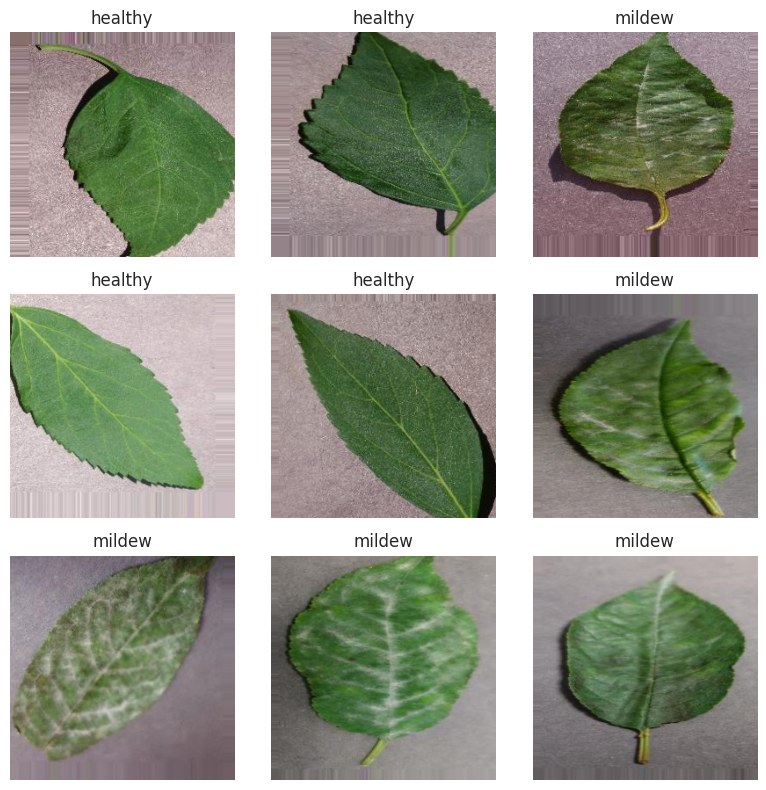

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(train_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Augmented Validation Image Set**

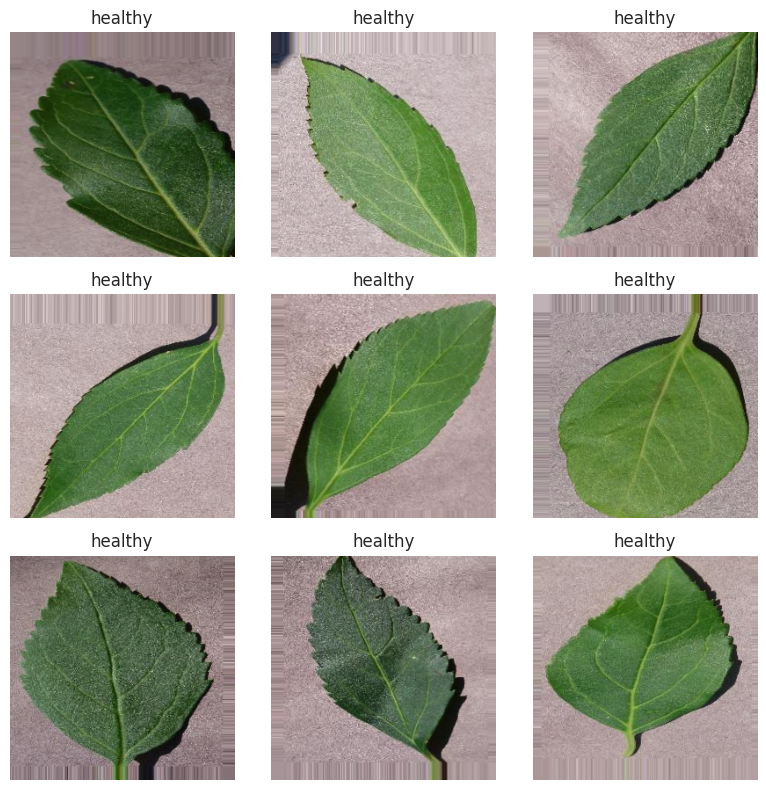

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(validation_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Augmented Test Image Set**

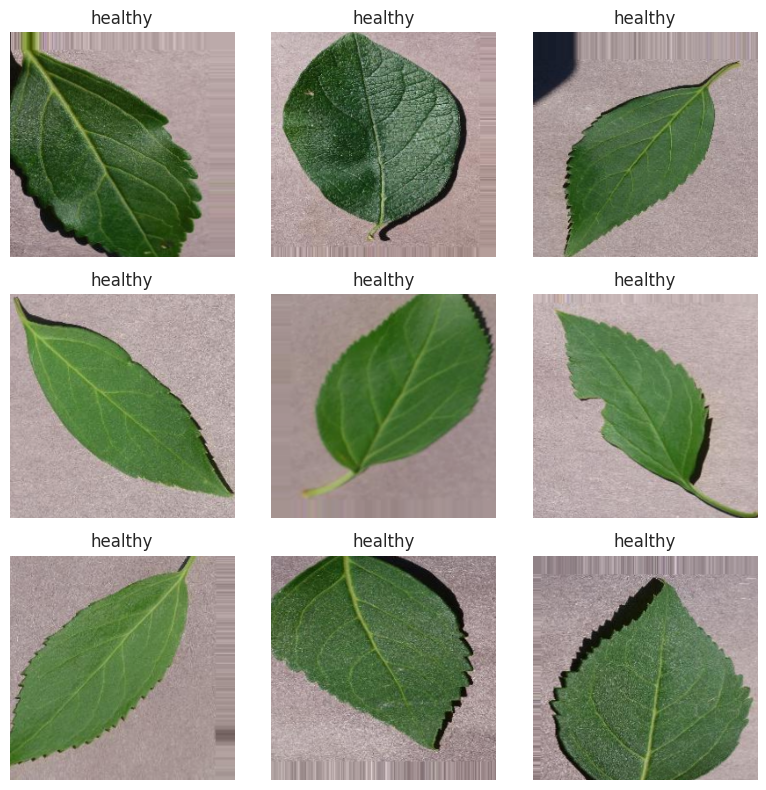

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(test_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Save class_indicies**

In [28]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Building the Model

**Import Model Packages**

In [45]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

### Model

In [51]:
def build_model():
    """
    Description:
        Builds a convolutional neural network (CNN) model

    Parameters:
        image_shape - tuple: The shape of input images (height, width, channels)

    Returns:
        model - Sequential: A TensorFlow Keras Sequential model
    """

    model = Sequential()

    # Input Layer
    model.add(Conv2D(filters=16,
                     kernel_size=(3, 3),
                     input_shape=image_shape,
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layers
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [52]:
model = build_model()

In [53]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,710,113 (14.15 MB)

 Trainable params: 3,710,113 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

**Early Stopping**

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

### Model Training

**Model Fit**

In [56]:
model.fit(train_set,
          batch_size=batch_size,
          epochs=20,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 258ms/step - accuracy: 0.7302 - loss: 0.5784 - val_accuracy: 0.9238 - val_loss: 0.1456
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 48s 255ms/step - accuracy: 0.9707 - loss: 0.0926 - val_accuracy: 0.9905 - val_loss: 0.0650
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 48s 254ms/step - accuracy: 0.9718 - loss: 0.0833 - val_accuracy: 0.9881 - val_loss: 0.0447
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 48s 254ms/step - accuracy: 0.9918 - loss: 0.0316 - val_accuracy: 0.9881 - val_loss: 0.0515
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 53s 283ms/step - accuracy: 0.9886 - loss: 0.0316 - val_accuracy: 0.9952 - val_loss: 0.0148
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 52s 273ms/step - accuracy: 0.9956 - loss: 0.0201 - val_accuracy: 0.9952 - val_loss: 0.0134
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 84s 448ms/step - accuracy: 0.9871 - loss: 0.0450 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 71s 375ms/step - accuracy: 0.9980 - loss: 0

**Save Model**

In [57]:
model.save(f'outputs/{version}/mildew_detector_model.keras')

---

## Model Performance

**Model Learning Curve**

In [58]:
losses = pd.DataFrame(model.history.history)

**Loss**

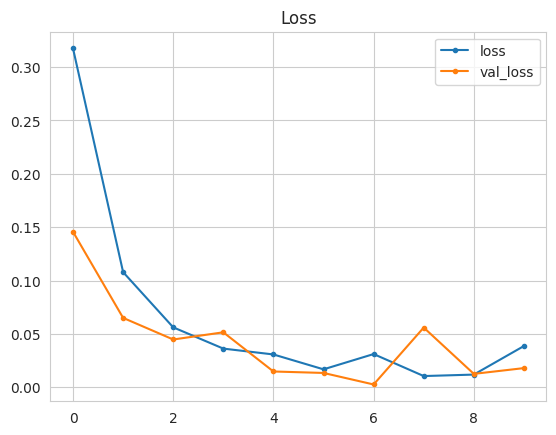

In [59]:
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")

plt.savefig(f'{file_path}/model_loss_training.png',
            bbox_inches='tight', dpi=150)

plt.show()

**Accuracy**

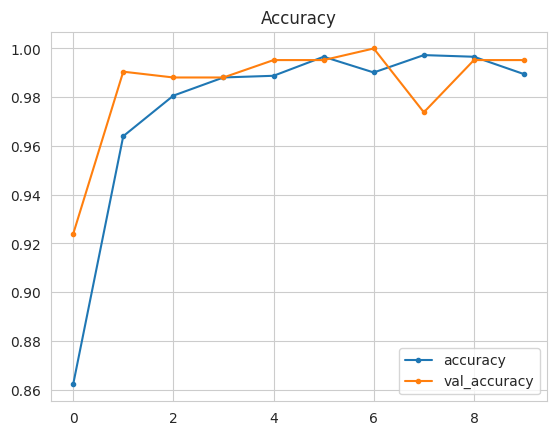

In [60]:
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")

plt.savefig(f'{file_path}/model_accuracy_training.png',
            bbox_inches='tight', dpi=150)

plt.show()

**Loss and Accuracy**

---

## Model Evaluation

**Load Model**

In [61]:
from tensorflow.keras.models import load_model

In [63]:
evaluation = model.evaluate(test_set)

/workspace/.pip-modules/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.9955 - loss: 0.0099


In [64]:
joblib.dump(value=evaluation,
            filename=f"outputs/{version}/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

## Predict on new data

In [79]:
import numpy as np

Image shape: (256, 256), Image mode: RGB


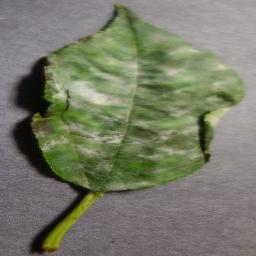

In [80]:
from tensorflow.keras.preprocessing import image
import os

pointer = 77
label = labels[1]

image_path = os.path.join(
    test_path, label, os.listdir(os.path.join(test_path, label))[pointer])

pil_image = image.load_img(image_path,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [81]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


In [82]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
mildew 100.0%
